In [1]:
!pip install torch torchvision
!pip install d2l==1.0.0b0


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python -m pip install --upgrade pip


# That TensorBoard playground

Did you beat me?

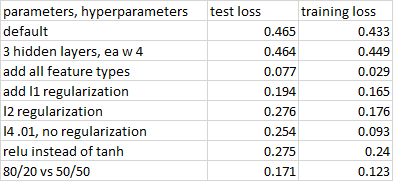

# Review

* What does a linear regression look like (function)?
* When we fit a linear regression using a simple neural network:
  * What is the width of the input layer?
  * What is the width of the output layer?
  * What type of neural network is it, in terms of connections?
  * What are the parameters?
  * What does the loss function look like (function)?



## Linear Regression as a Neural Network In pytorch

First, we install required libraries.

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

We make the linear regression model architecture. Notice how in the constructor we have to specify:
* the number of inputs (width of the input layer)
* the learning rate (a *hyperparameter* of the optimization algorithm)
* sigma (another *hyperparameter* of the otpimization algorithm)

Then, we define how the neural network's neurons are connected.
* When we run a neural network - when we push data through til the output layer on a single data point - that's called a *forward pass*. 
* The forward pass implementation tells us how the input layer is connected to the output layer. We always represent this as matrix multiply of some kind.
* *What does the forward pass do in this case?*

And then, we define the loss function.

In [43]:
class LinearRegressionScratch(d2l.Module):  #@save
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        print(self.w)
        self.b = torch.zeros(1, requires_grad=True)
        print(self.b)

    def forward(self, X):
        return torch.matmul(X, self.w) + self.b
    
    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2
        return l.mean()

Now we said before we would use *gradient descent* to train this model. Remember the boats from last class session?

Classic (pure) gradient descent goes like this:
1. Run *forward* on all your data.
2. Calculate the derivative of the *loss*.
3. Multiply the gradient by the *learning rate*.
4. Subtract that value from each of the model's parameters (in this case, $w$s and $b$). This step is called *backpropagation*.

However, this can be computationally expensive. There are many variants of gradient descent that are more efficient, including:
* Stochastic gradient descent - at each round, pick one training data point (at random) and run gradient descent just with that. 
* Minibatch stochastic gradient descent - at each round, pick $n$ training data points (at random) and run gradient descent just with that. (Normalize the learning rate by the minibatch size.)

What do we initialize the $w$ s and $b$ to at the beginning? Random values.

When do we stop? When either of the following is satisfied:
1. The loss has pretty much stopped changing.
2. We've run it for a preset maximum number of *epochs*.

In [44]:
class SGD(d2l.HyperParameters):  #@save
    def __init__(self, params, lr):
        """Minibatch stochastic gradient descent."""
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

We add this optimization algorithm to our linear regression model.

In [45]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

Then we augment the default pytorch trainer (defined in the book). It implements:
* for each epoch:
  * for each minibatch in the training data:
    * run forward (training_step)
    * calculate the loss
    * backward propagate the loss 
  * run evaluation on the validation data, report loss

In [94]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

Let's try it on a dataset of used car prices.

In [147]:
import pandas as pd
from sklearn.model_selection import train_test_split

class UsedCarData(d2l.DataModule):  #@save
    def __init__(self, batch_size, path="data/vehiclesNumeric.csv"):
        super().__init__()
        self.save_hyperparameters()
        df = pd.read_csv(path).apply(lambda x: (x - x.mean()) / (x.std()))
        # we drop the datapoint id from the features
        features = df.iloc[:, 2:4]
        # the labels are the prices
        labels = df.iloc[:, 1]
        #print(features.shape, labels.shape)
        
        # split the dataset
        self.train, self.val, self.train_y, self.val_y = train_test_split(features, labels, test_size=0.2, shuffle=False)
        #print(self.train.shape, self.val.shape)
        print("train", self.train[0:10], "y", self.train_y[0:10])

    def get_dataloader(self, train):
        features = self.train if train else self.val
        labels = self.train_y if train else self.val_y
        get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
        tensors = (get_tensor(features), get_tensor(labels))
        return self.get_tensorloader(tensors, train)

In [148]:
model = LinearRegressionScratch(2, lr=0.03)
data = UsedCarData(batch_size=10)

tensor([[-0.0059],
        [ 0.0072]], requires_grad=True)
tensor([0.], requires_grad=True)
train        year  odometer
0  0.404763  0.034629
1 -0.595817  0.010004
2  0.154618  0.049319
3  0.404763  0.034629
4  0.404763  0.034629
5 -0.095527 -0.190219
6 -0.095527 -0.142637
7  1.405343 -0.300866
8 -0.345672 -0.241268
9 -0.845962 -0.076340 y 0    0.362517
1   -0.447038
2    0.274491
3    0.362517
4    0.524861
5    0.635255
6    0.328606
7    2.150466
8   -0.086273
9   -0.681535
Name: price, dtype: float64
X shape: torch.Size([10, 2]) 
y shape: torch.Size([10])
tensor([[ 0.6549, -0.2766],
        [ 0.1546, -0.2452],
        [-0.3457, -0.0763],
        [ 0.1546,  0.0165],
        [-0.8460,  0.1553],
        [ 0.1546,  0.0437],
        [-1.8465, -0.2656],
        [ 0.1546, -0.0398],
        [ 0.1546,  0.0162],
        [-0.0955,  0.1436]]) tensor([ 2.5284, -0.1774, -0.0863, -0.0322, -0.1945,  0.1834,  0.3647, -0.0953,
        -1.4238, -0.4470])


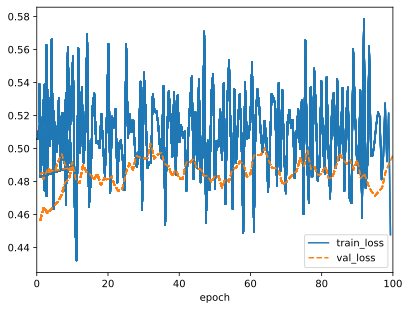

In [150]:
trainer = d2l.Trainer(max_epochs=100)
trainer.fit(model, data)

*What happens when you change the number of epochs?*

*What happens when you change the learning rate?*

*How does all this compare to your project 1 adaline class?*

# Deep Dive on Gradient Descent

Alex Strick van Linschoten has a great overview of [gradient descent](https://mlops.systems/posts/2022-05-12-seven-steps-gradient-calculations.html). Let's take a look.
1. Initialise a set of weights
2. Use the weights to make a prediction
3. Loss: see how well we did with our predictions
4. Calculate the gradients across all the weights
5. ‘Step’: Update the weights
6. Repeat starting at step 2
7. Iterate until we decide to stop







Now let's take a deeper look at that SGD class we've been subclassing.